# Validation

In [4]:
import sys
sys.path.append("../")

from __init__ import *
from data_tools import *
from testing import *

## Calculating Tau

The first thing to note is the Tau value of our data. Let us choose an event, take a 40.96 $\mu s$ time slice, calculate an FFT and also observe the associated truth data.

In [5]:
file = path + '90harmonic.h5'

strings, attributes, attributes_values = get_attributes(file)
print(strings[0], "has a", attributes[9], 'equal to', attributes_values[0][9], 'Ohms')

signal = get_signal(file, strings[0])
no_samples = 40960 # For a 40.96 us time slice

signal_fft = np.fft.rfft(signal, no_samples)

print('Time slice is', no_samples * 1e-9 * 1e6, ' micro seconds')
print('With a total number of ', len(np.abs(signal_fft)), 'Bins')

signal1 has a Waveguide impedance [Ohms] equal to 496.1709043911709 Ohms
Time slice is 40.96  micro seconds
With a total number of  20481 Bins


Tau is defined as 
$$ \tau = kTBR / N_{FFT} $$

In [6]:
R = attributes_values[0][9]
N_fft = len(np.abs(signal_fft))

tau = k * T * B * R / N_fft
print(tau)

8.357939652114349e-16


## Validating Rayleigh Distributions

Testing a single Rayleigh bin with manual and scipy implementation (with scaling)

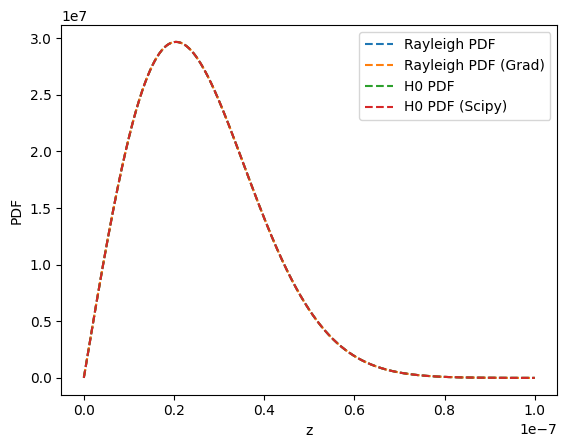

KS Test Results:
Comparison 1 vs 2: KS Statistic = 0.00200000, p-value = 1.00000000
Comparison 1 vs 3: KS Statistic = 0.00200000, p-value = 1.00000000
Comparison 1 vs 4: KS Statistic = 0.00200000, p-value = 1.00000000
Comparison 2 vs 3: KS Statistic = 0.00200000, p-value = 1.00000000
Comparison 2 vs 4: KS Statistic = 0.00200000, p-value = 1.00000000
Comparison 3 vs 4: KS Statistic = 0.00000000, p-value = 1.00000000


/Users/nathan/miniforge3/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


In [7]:
z_values = np.linspace(0, 1e-7, 1000)
N_bin = 1

# No Scipy 
null_dist = H0_PDF(z_values, tau, 1, scipy=False)

# Scipy
null_dist_scipy = H0_PDF(z_values, tau, 1, scipy=True) 

# Numerical Differentiation
ray_cdf_dist = rayleigh_CDF(z_values, tau, N_bin=1)
ray_pdf_dist = numerical_derivative_rayleigh_CDF(z_values, tau, N_bin, delta=1e-10)

# Numerical Differentiation pt.2
ray_pdf_dist_grad = np.gradient(ray_cdf_dist, z_values)

plt.plot(z_values, ray_pdf_dist, label='Rayleigh PDF', linestyle='--')
plt.plot(z_values, ray_pdf_dist_grad, label='Rayleigh PDF (Grad)', linestyle='--')

plt.plot(z_values, null_dist, label='H0 PDF', linestyle='--')
plt.plot(z_values, null_dist_scipy, label='H0 PDF (Scipy)', linestyle='--')
plt.legend()
plt.xlabel('z')
plt.ylabel('PDF')
plt.show();

# distributions = [pdf_dist, pdf_dist_grad, null_dist, null_dist_scipy]

# for dist in distributions:
#     print(scipy.integrate.trapezoid(dist, z_values))

# KS Test
distributions = [ray_pdf_dist, ray_pdf_dist_grad, null_dist, null_dist_scipy]

KS_test(distributions);

# Testing Rician

My experiments with trying to reproduce a manually coded Rician CDF and comparing with a scaled Scipy Rice Function have led to a few conclusions. The main one being that numerical stability is difficult to overcome. As we use smaller tau values (approaching our own tau of 1e-16) and decreasing z_ranges to narrow in on the area of interest (the curve of the CDF), we start to see divergence between my custom method (using log space) and the scipy implementation)

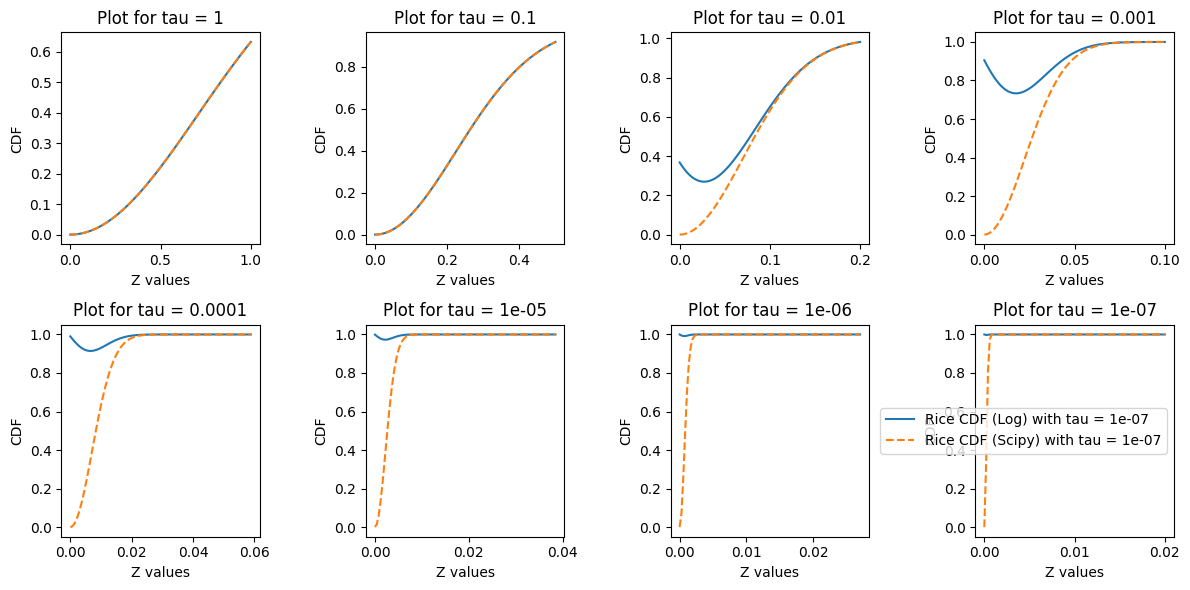

In [48]:
z_values = np.linspace(0, 1, 1000)
N_bin = 1
x_S = 1e-6
tau_rice = 1

tau_list = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

# Create a 2x4 grid of subplots (8 subplots in total)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Flatten the axes array to make iteration easier
axes = axes.flatten()

for i, tau_rice in enumerate(tau_list):
    ax = axes[i]
    
    z_values= np.linspace(0, 1/((i**2)+1), 100)
    
    # Calculate your rice distributions
    log_rice_dist = [rice_cdf_log_space(z, tau_rice, x_S) for z in z_values]
    rice_cdf_dist_scipy = rice_CDF(z_values, tau_rice, x_S)

    # Labels for the plots
    label_log = 'Rice CDF (Log) with tau = ' + str(tau_rice)
    label = 'Rice CDF (Scipy) with tau = ' + str(tau_rice)
    
    # Plot the two distributions on the corresponding subplot
    ax.plot(z_values, log_rice_dist, label=label_log)
    ax.plot(z_values, rice_cdf_dist_scipy, label=label, linestyle='--')
    
    # Set the title and labels
    ax.set_title(f'Plot for tau = {tau_rice}')
    ax.set_xlabel('Z values')
    ax.set_ylabel('CDF')

    # Add a legend
    
ax.legend()

# Adjust layout to ensure plots don't overlap
plt.tight_layout()

# Show the plots
plt.show()

One thing that we can be sure of is that when 

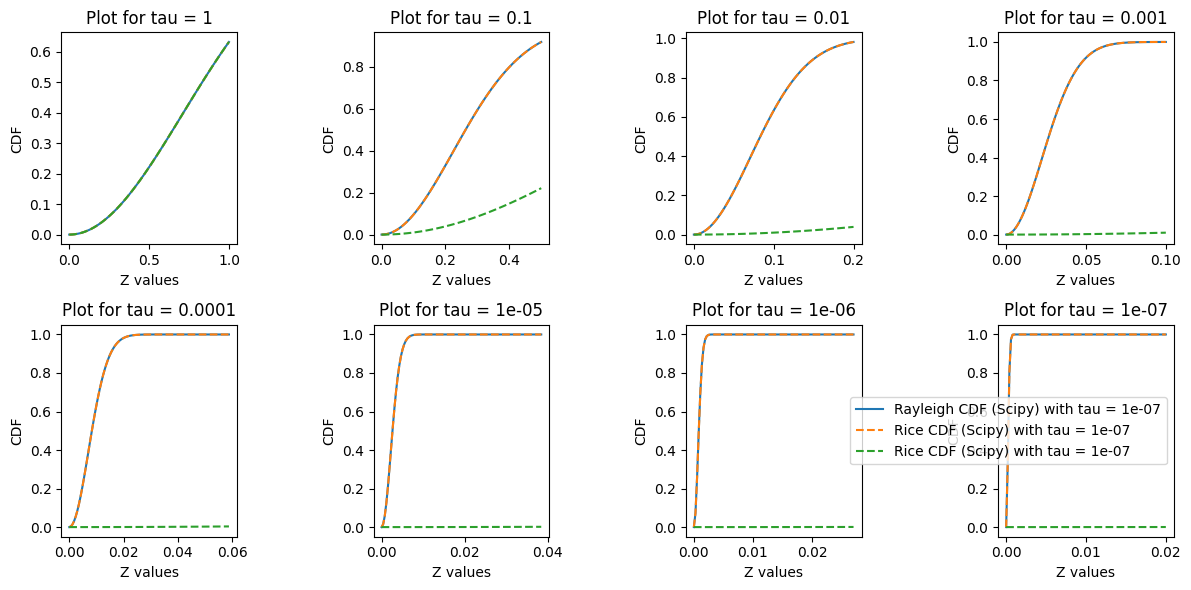

In [55]:

z_values = np.linspace(0, 1, 1000)
N_bin = 1
x_S = 1e-6
tau_rice = 1

tau_list = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

# Create a 2x4 grid of subplots (8 subplots in total)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Flatten the axes array to make iteration easier
axes = axes.flatten()

for i, tau_rice in enumerate(tau_list):
    ax = axes[i]
    
    z_values= np.linspace(0, 1/((i**2)+1), 100)
    
    # Calculate your rice distributions
    rice_cdf = rice_CDF(z_values, tau_rice, 0)
    ray_cdf = rayleigh_CDF(z_values, tau_rice, N_bin=1)
    rice_cdf_nonzero = rice_CDF(z_values, tau, x_S)


    # Labels for the plots
    label_rice = 'Rice CDF (Scipy) with tau = ' + str(tau_rice)
    label_ray = 'Rayleigh CDF (Scipy) with tau = ' + str(tau_rice)
    label_rice_nonzero = 'Rice CDF (Scipy) with tau = ' + str(tau_rice)
    
    # Plot the two distributions on the corresponding subplot
    ax.plot(z_values, ray_cdf, label=label_ray)
    ax.plot(z_values, rice_cdf, label=label_rice, linestyle='--')
    ax.plot(z_values, rice_cdf_nonzero, label=label_rice_nonzero, linestyle='--')
    
    # Set the title and labels
    ax.set_title(f'Plot for tau = {tau_rice}')
    ax.set_xlabel('Z values')
    ax.set_ylabel('CDF')

    # Add a legend
    
ax.legend()

# Adjust layout to ensure plots don't overlap
plt.tight_layout()

# Show the plots
plt.show()


# rice_cdf = rice_CDF(z_values, tau, 0)
# ray_cdf = rayleigh_CDF(z_values, tau, N_bin=1)



# plt.plot(z_values, rice_cdf, label='Rice CDF')
# plt.plot(z_values, ray_cdf, label='Rayleigh CDF', linestyle='--')
# plt.plot(z_values, rice_cdf_nonzero, label='Rice CDF (Non-Zero)', linestyle='--')
# plt.legend()
# plt.show()

Testing a single Rician bin with manual and scipy implementation (with scaling)

## Computing F1

So now we will take 2 bins. One scenario where we assume both to be noise, one where there is a realistic signal in one and noise in the other and a final one consisting of two signal bins.

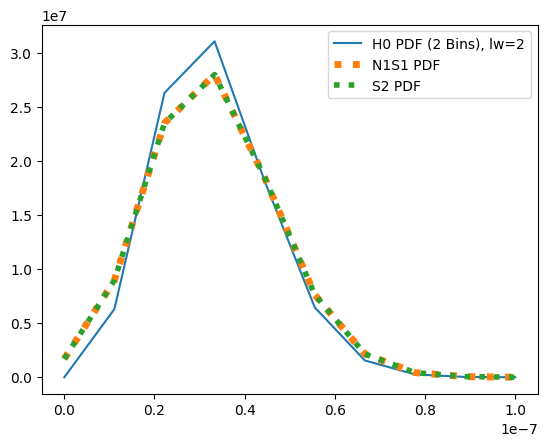

KS Test Results:
Comparison 1 vs 2: KS Statistic = 0.11800000, p-value = 0.99616129
Comparison 1 vs 3: KS Statistic = 0.11800000, p-value = 0.99616129
Comparison 2 vs 3: KS Statistic = 0.10000000, p-value = 1.00000000


In [ ]:
N_bin = 2
x_S = [1e-6, 1e-6]
x_k = 1e-6
z_values = np.linspace(0, 1e-7, 10)

## Noisy 
null_dist_scipy_2bin = H0_PDF(z_values, tau, N_bin, scipy=True) 

## N1S1
rice_part = rice_CDF(z_values, tau, x_k)
ray_part = rayleigh_CDF(z_values, tau, N_bin=1)
N1S1_pdf_dist = np.gradient(rice_part * ray_part, z_values)

## S2
result_container = np.zeros(shape=(len(x_S),len(z_values)))
for i in range(len(x_S)):
    result = rice_CDF(z_values, tau, x_S[i])
    result_container[i] = result
        
result_product = np.prod(result_container, axis=0)
signal_pdf = np.gradient(result_product, z_values)


# Plotting
plt.plot(z_values, null_dist_scipy_2bin, label='H0 PDF (2 Bins), lw=2')
plt.plot(z_values, N1S1_pdf_dist, label='N1S1 PDF', linestyle=':', lw=5)
plt.plot(z_values, signal_pdf, label='S2 PDF', linestyle='dotted', lw=4)
plt.legend()
plt.show()

# Testing
distributions = [null_dist_scipy, N1S1_pdf_dist, signal_pdf]

# print("Integrals of the PDFs")
# get_integral(distributions, z_values)

print("======================")

KS_test(distributions);

[[0.         0.13732046 0.44614256 0.7353661  0.90589949 0.97509782
  0.99509564 0.99928117 0.99992159 0.99999363]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.   

ValueError: x and y must have same first dimension, but have shapes (10,) and (1000,)

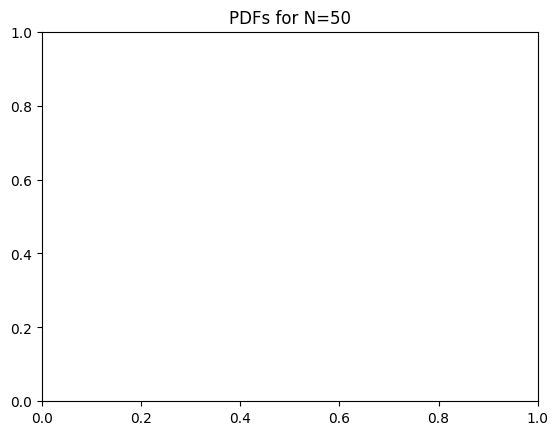

In [ ]:
N_bin = 50
x_S = [1e-6] * N_bin
x_k = 1e-6
z_values = np.linspace(0, 1e-7, 10)

## Noisy 
null_dist_scipy_2bin = H0_PDF(z_values, tau, N_bin, scipy=True) 

## N1S1
rice_part = rice_CDF(z_values, tau, x_k)
ray_part = rayleigh_CDF(z_values, tau, N_bin=N_bin-1)
N1S1_pdf_dist = np.gradient(rice_part * ray_part, z_values)

## S3
result_container = np.zeros(shape=(len(x_S),len(z_values)))
for i in range(len(x_S)):
    result = rice_CDF(z_values, tau, x_S[i])
    result_container[i] = result
    print(result_container)
        
result_product = np.prod(result_container, axis=0)
signal_pdf = np.gradient(result_product, z_values)


# Plotting
title = 'PDFs for N=' + str(N_bin)
plt.title(title)
plt.plot(z_values, null_dist_scipy, label='H0 PDF', linestyle='--')
plt.plot(z_values, N1S1_pdf_dist, label='N49S1 PDF', linestyle='--')
plt.plot(z_values, signal_pdf, label='S50 PDF', linestyle='-.')
plt.legend()
plt.show()

# Testing
distributions = [null_dist_scipy, N1S1_pdf_dist, signal_pdf]

print("Integrals of the PDFs")
get_integral(distributions, z_values)

print("======================")

KS_test(distributions);

Now a larger dummy test

In [ ]:
arr = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
arr_1 = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

arr_3 = [arr, arr_1]
np.prod(arr_3, axis=0)

array([  1,   4,   9,  16,  25,  36,  49,  64,  81, 100])

Real data test for all the different pitch angles. 

In [ ]:
# Define the Rice CDF
def rice_cdf(z, tau, x_k):
    def integrand(tilde_z):
        return (2 * tilde_z / tau) * np.exp(-(tilde_z**2 + x_k**2) / tau) * i0(2 * tilde_z * x_k / tau)
    integral, _ = integrate.quad(integrand, z, 1e-6)
    return 1 - integral

values = rice_cdf(z_values, tau, 1e-6)

plt.plot(z_values, values)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [20]:


def rice_cdf_log_space(z, tau, x_k):
    """Compute the Rician CDF at z with parameters tau and x_k using log-space calculations."""
    
    def integrand_log_space(tilde_z, tau, x_k):
        # Handle the case where x_k is very small
        if x_k < 1e-8:
            # If x_k is too small, the Bessel function approaches 1, and we can approximate it
            log_bessel_term = 0
        else:
            # Otherwise calculate the Bessel function normally
            bessel_argument = (2 * tilde_z * x_k) / tau
            bessel_val = i0(bessel_argument)
            log_bessel_term = np.log(bessel_val) if bessel_val > 0 else -np.inf
        
        # Logarithmic terms to avoid underflow
        prefactor = 2 * tilde_z / tau
        log_term1 = np.log(prefactor) if prefactor > 0 else -np.inf
        
        exp_term = -(tilde_z**2 + x_k**2) / tau
        
        # Return the sum of terms in log space and exponentiate at the end
        return np.exp(log_term1 + exp_term + log_bessel_term)
    
    # Set a finite upper limit to prevent nan issues
    upper_limit = z + 10 * tau  # Adjust this based on tau, though tau is very small here
    
    # Perform the integration using adaptive quadrature
    integral_result, _ = quad(integrand_log_space, z, upper_limit, args=(tau, x_k), limit=100)
    
    # Return the CDF value
    return 1 - integral_result

# Example usage
tau = 1   # very small variance parameter (2 * sigma^2)
x_k = 1e-6                     # non-centrality parameter (nu), now smaller
z_values = np.linspace(0, 1, 10)
cdf_values = [rice_cdf_log_space(z, tau, x_k) for z in z_values]

# Print a few results
for z, cdf in zip(z_values[:10], cdf_values[:10]):
    print(f"Rician CDF at z = {z:.10f}: {cdf:.8f}")

Rician CDF at z = 0.0000000000: 0.00000000
Rician CDF at z = 0.1111111111: 0.01226978
Rician CDF at z = 0.2222222222: 0.04818322
Rician CDF at z = 0.3333333333: 0.10516068
Rician CDF at z = 0.4444444444: 0.17924519
Rician CDF at z = 0.5555555556: 0.26555633
Rician CDF at z = 0.6666666667: 0.35881961
Rician CDF at z = 0.7777777778: 0.45389186
Rician CDF at z = 0.8888888889: 0.54621123
Rician CDF at z = 1.0000000000: 0.63212056


In [21]:
print(scipy.stats.rice.cdf(z_values, b=x_k, loc=0, scale=np.sqrt(1/2)))

[0.         0.01226978 0.04818322 0.10516068 0.17924519 0.26555633
 0.35881961 0.45389186 0.54621123 0.63212056]
